### Vehicle Collision Analysis

Analyst: Daniel Elkin <br />
Date: 06/12/2019

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
from scipy.stats import ttest_ind

In [2]:
%matplotlib inline

### Contents:
* [I. Data Loading and Validation](#load)
* [II. Collision Times](#times)
* [III. Vehicle Types](#types)
    * [a. Fatalities](#fatalities)
    * [b. Injuries](#injuries)

#### I. Data Loading and Validation <a id="load"/>

First we'll load the data.

In [3]:
data_file = "data/NYPD_Motor_Vehicle_Collisions.csv"

rows = !wc -l < $data_file
rows = int(rows[0])

print(f"There are {rows} rows in the data file.")

There are 1509271 rows in the data file.


In [4]:
# the columns of interest for the questions in the prompt
cols = [
    "DATE",
    "TIME",
    "BOROUGH",                                          
    "NUMBER OF PERSONS INJURED",        
    "NUMBER OF PERSONS KILLED",       
    "NUMBER OF PEDESTRIANS INJURED",    
    "NUMBER OF PEDESTRIANS KILLED",     
    "NUMBER OF CYCLIST INJURED",        
    "NUMBER OF CYCLIST KILLED",         
    "NUMBER OF MOTORIST INJURED",       
    "NUMBER OF MOTORIST KILLED",        
    "UNIQUE KEY",                       
    "VEHICLE TYPE CODE 1",              
    "VEHICLE TYPE CODE 2",              
    "VEHICLE TYPE CODE 3",              
    "VEHICLE TYPE CODE 4",              
    "VEHICLE TYPE CODE 5"
]   

df = pd.read_csv(data_file, 
                 parse_dates=[["DATE", "TIME"]],
                 usecols=cols)

In [5]:
# confirm we've loaded all rows
len(df)

1509269

Next, we'll rename the columns for readability and use only the data from 2018.

In [6]:
df.rename(columns=lambda c: c.lower().replace(" ", "_"), inplace=True)
df = df[df.date_time.dt.year == 2018]

Let's examine the remaining data for potential issues.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 269 to 320494
Data columns (total 16 columns):
date_time                        231485 non-null datetime64[ns]
borough                          149173 non-null object
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
unique_key                       231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null o

In [8]:
# ensure that the unique key is really unique
assert len(df.unique_key) == len(df.unique_key.unique())

In [9]:
# see how many null values we have
df.isnull().sum()

date_time                             0
borough                           82312
number_of_persons_injured             5
number_of_persons_killed             14
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
unique_key                            0
vehicle_type_code_1                1397
vehicle_type_code_2               49022
vehicle_type_code_3              217632
vehicle_type_code_4              228613
vehicle_type_code_5              230723
dtype: int64

We have 231,485 collisions in the dataset. We've confirmed that the data is complete for the `date_time` and `unique_key` columns. We'll further examine and clean the data below.

#### II. Collision times <a id="times"/>

We'll create a new dataframe with only the columns needed to answer the question of when collisions occur.

In [72]:
# subset the fields needed
df1 = df[["date_time", "unique_key", "borough"]].copy()

# add a derived column for day of week
df1["day_of_week"] = df1.date_time.dt.weekday_name

# make the time of the collision the index
df1.set_index("date_time", inplace=True)

df1.head()

,unique_key,borough,day_of_week
date_time,,,
2018-12-29 19:45:00,4055860,NaN,Saturday
2018-12-24 10:00:00,4055249,NaN,Monday
2018-12-17 14:30:00,4047978,NaN,Monday
2018-12-31 00:00:00,4055273,BRONX,Monday
2018-12-31 00:00:00,4055449,BROOKLYN,Monday


We'll bin the collisions by the hour at which they occur and plot them.

<a id='by-hour'></a>

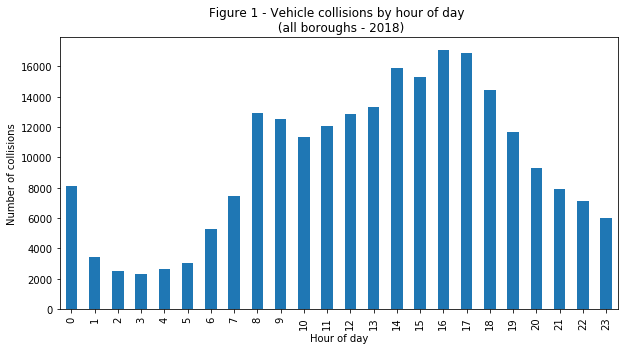

In [79]:
group = df1.groupby(df1.index.hour).count().unique_key
ax = group.plot(kind="bar", 
                figsize=(10, 5),
                title="Figure 1 - Vehicle collisions by hour of day \n (all boroughs - 2018)")

ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of collisions")
ax.figure.savefig("figures/fig_1.png")

In [21]:
print(f"Mean collisions in early morning: {group[1:6].sum() / 5}")
print(f"Mean collisions in afternoon rush hour: {group[16:18].sum() / 2}")

Mean collisions in early morning: 2788.8
Mean collisions in afternoon rush hour: 16980.5


We do not have complete data for the boroughs in which collisions occur, but we can visualize the data we do have by borough as well.

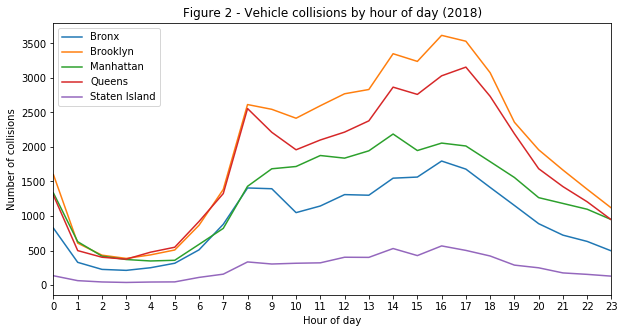

In [80]:
group = (df1.groupby([df1.index.hour, "borough"])
         .unique_key
         .count()
         .unstack())

ax = group.plot(figsize=(10, 5), 
                xticks=range(0, 24), 
                title="Figure 2 - Vehicle collisions by hour of day (2018)")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of collisions")

# rename the legends so values are not all uppercase 
boroughs = [str(b).title() 
            for b in df1.borough.dropna().unique()]
ax.legend(boroughs)
ax.figure.savefig("figures/fig_2.png")

We will discuss further in the conclusion, but the graphs reveal that most accidents occur during the day, particularly between the hours of 4:00 and 6:00pm.

<a id="days" />

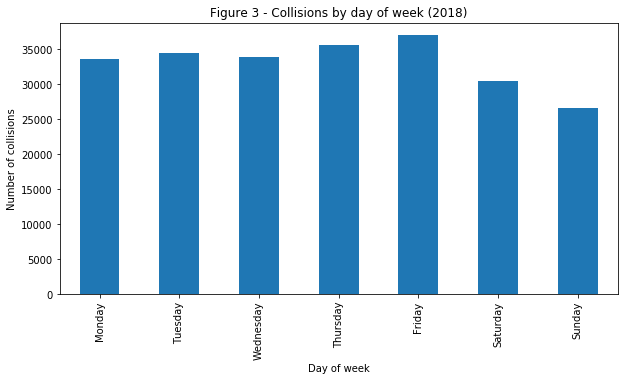

In [95]:
# order the grouped dataframe by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group = (df1.groupby(["day_of_week"])
         .count()
         .unique_key
         .reindex(days))

plt.pyplot.tight_layout()
ax = group.plot(figsize=(10, 5), 
           kind="bar", 
           title="Figure 3 - Collisions by day of week (2018)")

ax.set_xlabel("Day of week")
ax.set_ylabel("Number of collisions")
ax.figure.savefig("figures/fig_3.png")

More collisions also occur on weekdays than weekends.

In [16]:
print(f"Average collisions on weekdays {group[:5].sum() / 5}")
print(f"Average collisions on weekends {group[5:].sum() / 2}")

Average collisions on weekdays 34887.4
Average collisions on weekends 28524.0


#### III. Vehicle type <a id="types" />